# Spectral Products: Vegetation, Water, Urbanization

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'my_app')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np  
import xarray as xr  

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

In [2]:
## LS8 Caqueta
# Latitude:  (0.000134747292617865, 1.077843593651382)  
# Longitude: (-74.91935994831539, -73.30266193148462)  
# '2013-04-13', '2018-03-26'
# Resolution: (-0.000269494585236, 0.000269494585236)

## LS8 Vietnam
# Latitude:  (10.513927001104687, 12.611133863411238)  
# Longitude: (106.79005909290998, 108.91906631627438)  
# '2014-01-14', '2016-12-21'
# Resolution: (-0.000269494585236, 0.000269494585236)

## LS7 Caqueta
# Latitude:  (0.000134747292617865, 1.077843593651382)  
# Longitude: (-74.91935994831539, -73.30266193148462)  
# '1999-08-21', '2018-03-25'
# Resolution: (-0.000269494585236, 0.000269494585236)

## LS7 Lake Baringo
# Latitude:  (0.4997747685, 0.7495947795)  
# Longitude: (35.9742163305, 36.473586859499996)  
# '2005-01-08', '2016-12-24'
# Resolution: (-0.000269493, 0.000269493)

In [3]:
# CHANGE HERE >>>>>>>>>>>>>>>>>

# Select a Product and Platform
# product = ls7_collection1_AMA_ingest
# platform = "LANDSAT_7"
product = 'ls8_collection1_AMA_ingest'
platform = "LANDSAT_8"

output_crs = 'EPSG:4326'
resolution = (-0.000269494585236, 0.000269494585236)

In [4]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>
# Select an analysis region (Lat-Lon) within the extents listed above. 
# HINT: Keep your region small (<0.5 deg square) to avoid memory overload issues
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

#Sub-region selection
# LS7 Lake Baringo
#latitude = (0.49964002, 0.76)
#longitude = (36.0, 36.16)
#time_extents = ('2015-01-01', '2018-01-01')

#LS8 Vietnam
latitude = (11.3124, 10.9124)
longitude = (106.9170, 107.3170) 
time_extents = ('2014-01-01', '2016-01-01')

In [5]:
# The code below renders a map that can be used to view the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## Load the dataset and the required spectral bands or other parameters

In [6]:
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          output_crs=output_crs,
                          resolution=resolution,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [7]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset

landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 1485, longitude: 1485, time: 12)
Coordinates:
  * time       (time) datetime64[ns] 2014-02-15T03:08:30 2014-06-07T03:07:19 ...
  * latitude   (latitude) float64 11.31 11.31 11.31 11.31 11.31 11.31 11.31 ...
  * longitude  (longitude) float64 106.9 106.9 106.9 106.9 106.9 106.9 106.9 ...
Data variables:
    red        (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    green      (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    blue       (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    nir        (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    swir1      (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    swir2      (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    pixel_qa   (time, latitude, longitude) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Attributes:
    crs:      EPSG:4326

### Mask out clouds and cloud shadows + water (if desired) and create a median mosaic

In [8]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask

cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
land_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform, cover_types=['clear'])

# Land and Water Dataset = Land and Water pixels with NO Clouds and NO Cloud Shadows
land_and_water_dataset = landsat_dataset.where(cloud_mask)

# Land Dataset = Land ONLY pixels with NO Clouds, NO Cloud Shadows and NO Water pixels
land_dataset = landsat_dataset.where(land_mask)

from utils.data_cube_utilities.dc_mosaic import create_median_mosaic, create_max_ndvi_mosaic, create_hdmedians_multiple_band_mosaic


In [9]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>

# Select a compositing method to create your cloud-filtered mosaic
# Remove the comments from the pair of lines under one of the mosaic types
# Options are: Median, Geomedian, or Max_NDVI 

# This is the MEDIAN mosaic
land_and_water_composite = create_median_mosaic(land_and_water_dataset, cloud_mask)
land_composite = create_median_mosaic(land_dataset, land_mask)

# This is the GEOMEDIAN mosaic
# land_and_water_composite = create_hdmedians_multiple_band_mosaic(land_and_water_dataset, cloud_mask)
# land_composite = create_hdmedians_multiple_band_mosaic(land_dataset, land_mask)

# This is the MAX_NDVI mosaic
# land_and_water_composite = create_max_ndvi_mosaic(land_and_water_dataset, cloud_mask)
# land_composite = create_max_ndvi_mosaic(land_dataset, land_mask)


(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f63f075e940>)

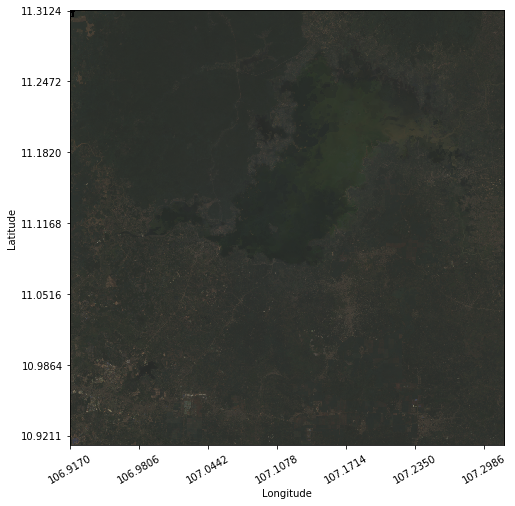

In [10]:
# Show the land and water composite
from utils.data_cube_utilities.dc_rgb import rgb
rgb(land_and_water_composite)

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f633f834b38>)

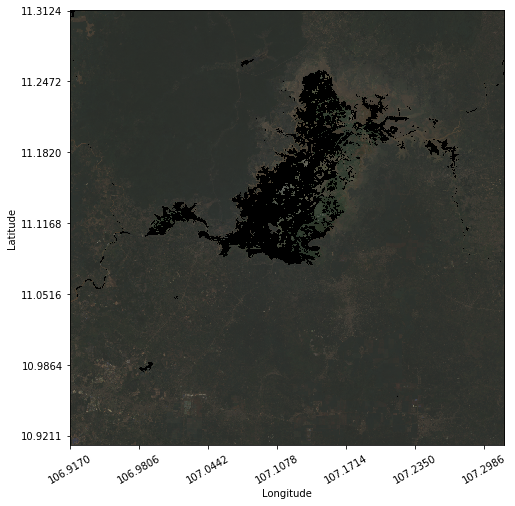

In [11]:
# Show the land-only composite (water will be removed ... black pixels)
from utils.data_cube_utilities.dc_rgb import rgb
rgb(land_composite)

# Land Fractional Cover  

Fractional Cover (FC) is used for landcover type estimation (vegetation, non-green vegetation, bare soil) of each pixel. 
<br>We use a model from CSIRO (Juan Gerschmann) and apply it to a median mosaic.  
<br>
Bare Soil (bs), Photosynthetic Vegetation (pv), Non Photosynthetic Vegetation (npv)
<br>
Plot a False Color RGB result where RGB = bs/pv/npv

In [12]:
from utils.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
frac_classes = frac_coverage_classify(land_composite, clean_mask = np.ones(land_composite.pixel_qa.shape).astype(np.bool)) 

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f633df929b0>)

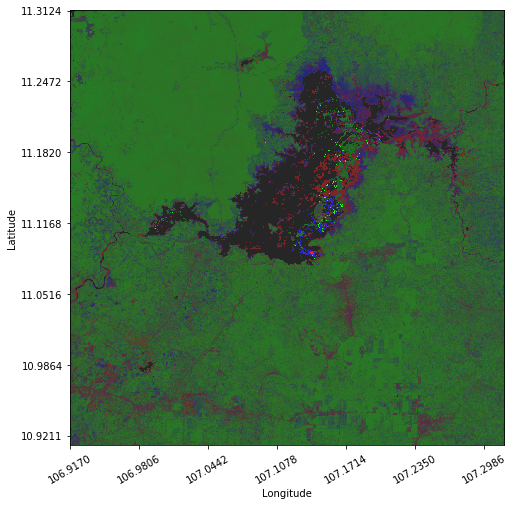

In [13]:
# Plot of Fractional Cover
# RED = Bare Soil or Urban Areas
# BLUE = Non-Green Vegetation
# GREEN = Green Vegetation
# BLACK = Water

rgb(frac_classes, bands = ['bs', 'pv', 'npv'], use_data_min=True, use_data_max=True) 

# Land Spectral Indices

In [14]:
def NDBI(dataset):
        return (dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)

In [15]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [16]:
def NDWI(dataset):
    return (dataset.green - dataset.nir)/(dataset.green + dataset.nir)

In [17]:
def SAVI(dataset):
        return (dataset.nir - dataset.red)/(dataset.nir + dataset.red + 0.5)*1.5

In [18]:
def EVI(dataset):
        return 2.5*(dataset.nir - dataset.red)/(dataset.nir + 6.0*dataset.red - 7.5*dataset.blue + 1.0)

In [19]:
ndbi = NDBI(land_composite)  # Normalized Difference Build Up (Urbanization) Index
ndvi = NDVI(land_composite)  # Normalized Difference Vegetation Index
ndwi = NDWI(land_composite) # Normalized Difference Water Index
ndbi2 = NDBI(land_and_water_composite)  # Normalized Difference Build Up (Urbanization) Index
ndvi2 = NDVI(land_and_water_composite)  # Normalized Difference Vegetation Index
ndwi2 = NDWI(land_and_water_composite) # Normalized Difference Water Index
savi = SAVI(land_composite)  # Soil Adjusted Vegetation Index 
evi = EVI(land_composite) # Enhanced Vegetation Index

In [20]:
ds_ndvi = ndvi2.to_dataset(name = "NDVI")
ds_ndwi = ndwi2.to_dataset(name=  "NDWI")
ds_ndbi = ndbi2.to_dataset(name = "NDBI")
normalization_dataset = ds_ndvi.merge(ds_ndwi).merge(ds_ndbi)

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f633df6e860>)

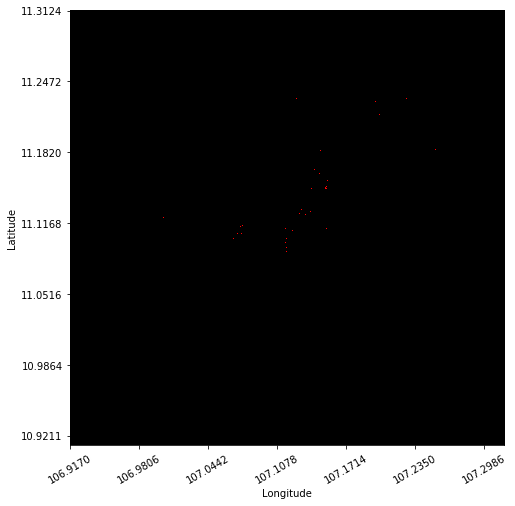

In [21]:
# Plot of RGB = NDBI-NDVI-NDWI
# RED = Bare Soil or Urban Areas
# GREEN = Vegetation
# BLUE = Water

rgb(normalization_dataset, bands = ['NDBI','NDVI','NDWI'], use_data_min=True, use_data_max=True) 

In [22]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

Populating the interactive namespace from numpy and matplotlib


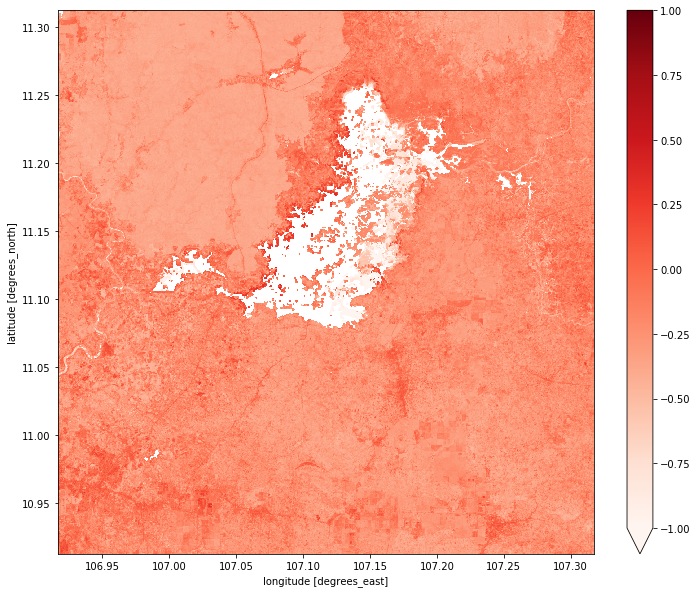

In [23]:
# May try cmap=GnBu or cmap=Greys, or cmap=Greens

(ndbi).plot(figsize=(12,10),cmap = "Reds", vmin=-1.0, vmax=1.0)

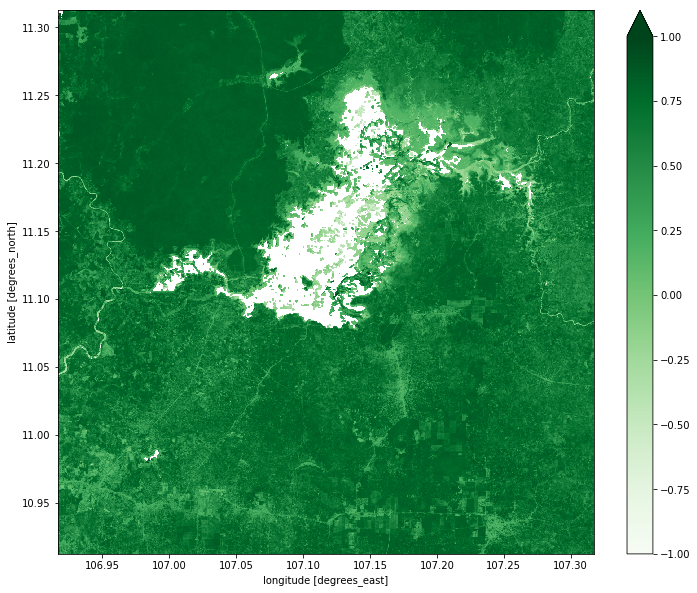

In [24]:
(ndvi).plot(figsize=(12,10), cmap = "Greens", vmin=-1.0, vmax=1.0)

In [25]:
# Create a custom colour map for NDVI
# Water (blue) = NDVI -1.0 to 0.0
# Urban or Bare Soil (brown) = NDVI 0.0 to 0.1
# Low Vegetation (tan) = NDVI 0.1 to 0.4
# Croplands (light green) = NDVI 0.4 to 0.6
# Dense Vegetation / Forests (dark green) = NDVI 0.6 to 1.0

ndvi_cmap = mpl.colors.ListedColormap(['blue', '#a52a2a','#ffffcc' ,  '#2eb82e',  '#006600'])
ndvi_bounds = [-1, 0, 0.1,  0.4,  0.6, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

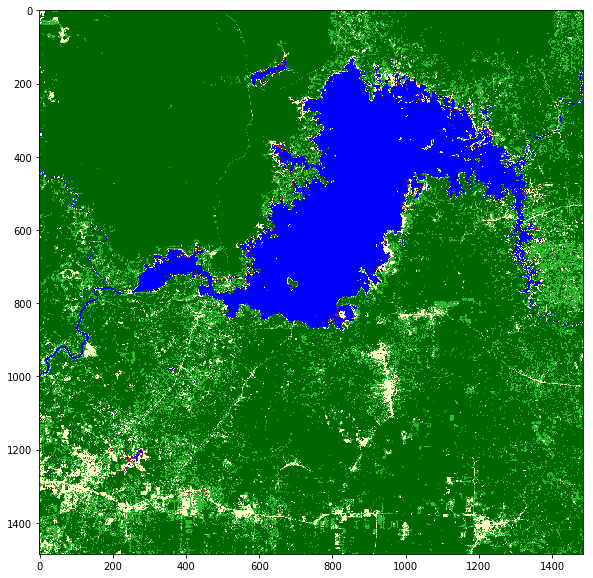

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(ndvi2, cmap = ndvi_cmap, norm = ndvi_norm)

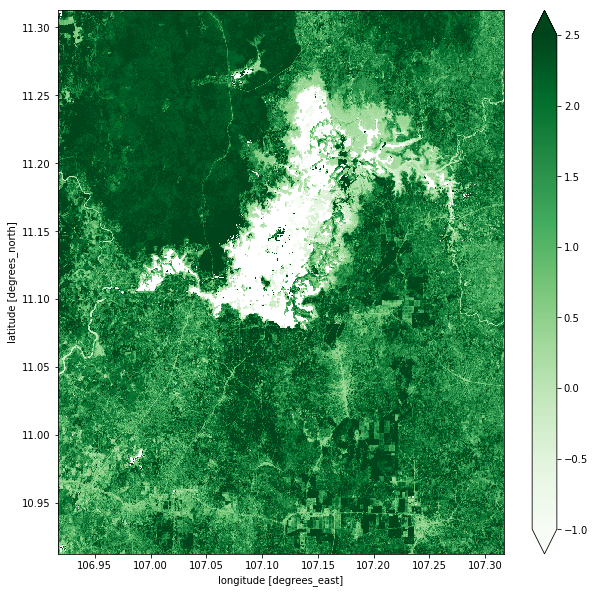

In [27]:
(evi).plot(figsize=(10,10), cmap = "Greens", vmin=-1.0, vmax=2.5)

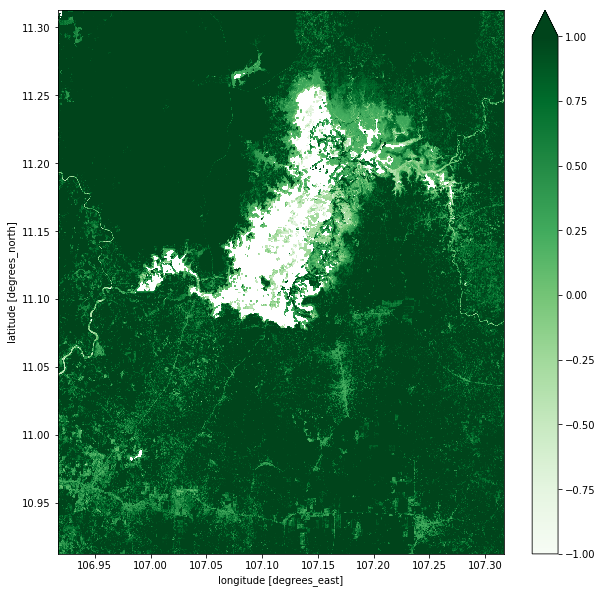

In [28]:
(savi).plot(figsize=(10,10), cmap = "Greens", vmin=-1.0, vmax=1.0)

# Water Products

### Normalized Difference Water Index (NDWI)

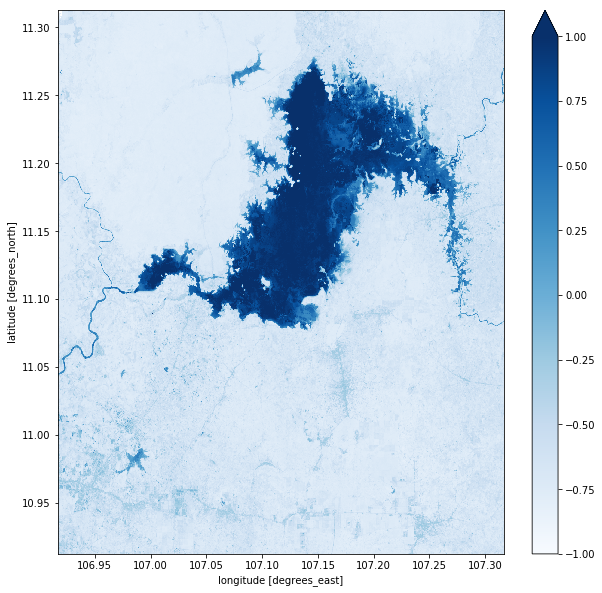

In [29]:
(ndwi2).plot(figsize=(10,10), cmap = "Blues", vmin=-1.0, vmax=1.0)

### Water Observation from Space (WOFS)
Developed by Geoscience Australia

In [30]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify

In [31]:
water_classification = wofs_classify(land_and_water_composite, clean_mask = np.ones(land_and_water_composite.pixel_qa.shape).astype(np.bool),  mosaic = True) 

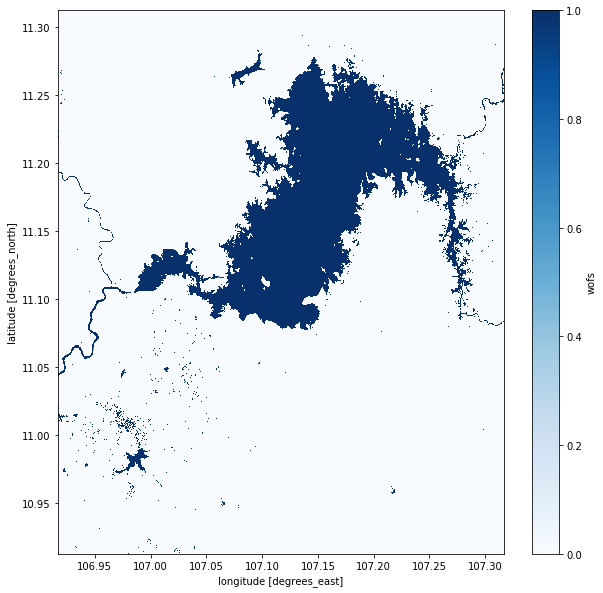

In [32]:
# Plot of WOFS product
# BLUE = 1.0 = Water
# WHITE = 0.0 = Non-Water

water_classification.wofs.plot(cmap='Blues')

## Create a threshold plot
First we will define a minimum threshold and a maximum threshold. Then you will create a plot that colors the region between the threshold a single color (e.g. red) and the region outside the threshold will be BLACK or WHITE. Also, we will calculate the % of pixels and the number of pixels in the threshold range.

In [33]:
from matplotlib.ticker import FuncFormatter

def threshold_plot(da, min_threshold, max_threshold, mask = None, width = 10, *args, **kwargs): 
    color_in    = np.array([255,0,0])
    color_out   = np.array([0,0,0])
    color_cloud = np.array([255,255,255])
    
    array = np.zeros((*da.values.shape, 3)).astype(np.int16)
    
    inside  = np.logical_and(da.values > min_threshold, da.values < max_threshold)
    outside = np.invert(inside)
    masked  = np.zeros(da.values.shape).astype(bool) if mask is None else mask
    
    array[inside] =  color_in
    array[outside] = color_out
    array[masked] =  color_cloud

    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.latitude) * (fixed_width / len(ds.longitude))
        return (width, height)


    fig, ax = plt.subplots(figsize = figure_ratio(da,fixed_width = width))
    
    lat_formatter = FuncFormatter(lambda y_val, tick_pos: "{0:.3f}".format(da.latitude.values[tick_pos] ))
    lon_formatter = FuncFormatter(lambda x_val, tick_pos: "{0:.3f}".format(da.longitude.values[tick_pos]))

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    plt.title("Threshold: {} < x < {}".format(min_threshold, max_threshold))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.imshow(array, *args, **kwargs)
    plt.show()

### Plot Threshold Product

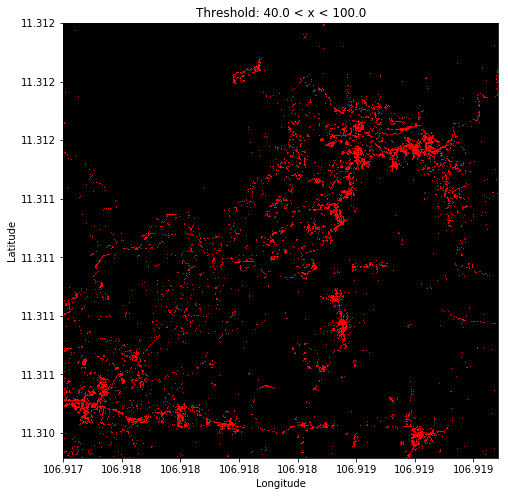

In [34]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>

# Select a threshold range for your spectral variable and generate a plot
# Remove comments from the set of 3 lines for your desired variable
# Variable choices are NDBI, NDVI, EVI, SAVI, FC-Bare Soil, FC-Photocynthetic Vegetation

# NDBI (Buildup Index) = -1.0 to 1.0 (full range)
# NDBI 0.0 to 0.2 is typical for urban areas
# -----------------------
# minimum_threshold = 0.0
# maximum_threshold = 0.2
# threshold_plot(ndbi, minimum_threshold, maximum_threshold, width = 8)

# NDVI (Vegetation Index) = -1.0 to 1.0
# NDVI < 0.0 = non-vegetation (bare soil)
# NDVI 0.2 to 0.6 = grasslands
# NDVI 0.6 to 0.9 = dense vegetation / trees
# -----------------------
# minimum_threshold = 0.2
# maximum_threshold = 0.6
# threshold_plot(ndvi, minimum_threshold, maximum_threshold, width = 8)

# EVI (Vegetation Index) = -1.0 to 2.5
# EVI 2.0 to 2.5 is typical for dense vegetation
# -----------------------
# minimum_threshold = 2.0
# maximum_threshold = 2.5
# threshold_plot(evi, minimum_threshold, maximum_threshold, width = 8)

# SAVI (Vegetation Index) = -1.0 to 1.0
# -----------------------
# minimum_threshold = 0.6
# maximum_threshold = 0.9
# threshold_plot(savi, minimum_threshold, maximum_threshold, width = 8)

# Fractional Cover (pv,npv,bs) = 0 to 100
# Bare Soil (bs) >40 = urbanization / bare soil
# ----------------------
minimum_threshold = 40.0
maximum_threshold = 100.0
threshold_plot(frac_classes.bs, minimum_threshold, maximum_threshold, width = 8)

# Fractional Cover (pv,npv,bs) = 0 to 100
# Vegetation (pv) >80 = dense green vegetation
# ----------------------
# minimum_threshold = 80.0
# maximum_threshold = 100.0
# threshold_plot(frac_classes.pv, minimum_threshold, maximum_threshold, width = 8)


In [35]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


In [36]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>

# Select a threshold statistical function that matches your land spectral variable
# COUNT = number of pixels in each category
# PERCENTAGE = percent of pixels in each category
# ---------------------------------

# NDBI Threshold
# threshold_count(ndbi,minimum_threshold,maximum_threshold)
# threshold_percentage(ndbi,minimum_threshold,maximum_threshold)

# NDVI Threshold
# threshold_count(ndvi,minimum_threshold,maximum_threshold)
# threshold_percentage(ndvi,minimum_threshold,maximum_threshold)

# EVI Threshold
# threshold_count(evi,minimum_threshold,maximum_threshold)
# threshold_percentage(evi,minimum_threshold,maximum_threshold)

# SAVI Threshold
# threshold_count(savi,minimum_threshold,maximum_threshold)
# threshold_percentage(savi,minimum_threshold,maximum_threshold)

# Fractional Cover - Bare Soil
# threshold_count(frac_classes.bs, minimum_threshold, maximum_threshold)
threshold_percentage(frac_classes.bs, minimum_threshold, maximum_threshold)

# Fractional Cover - Photosynthetic Vegetation
# threshold_count(frac_classes.pv, minimum_threshold, maximum_threshold)
# threshold_percentage(frac_classes.pv, minimum_threshold, maximum_threshold)


{'percent_inside_threshold': 3.9654457028194403,
 'percent_outside_threshold': 96.03455429718056,
 'percent_clouds': 0.0}

### Water Counts

In [37]:
# NDWI value for water = 0.0 to 1.0

ndwi_minimum_threshold = 0.0
ndwi_maximum_threshold = 1.0

In [38]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>>>>>>

# Select a threshold "count" or "percentage" statistical result
# COUNT = number of pixels in each category
# PERCENTAGE = percent of pixels in each category

# threshold_count(ndwi,ndwi_minimum_threshold,ndwi_maximum_threshold)
threshold_percentage(ndwi,ndwi_minimum_threshold,ndwi_maximum_threshold)

{'percent_inside_threshold': 1.531408359691188,
 'percent_outside_threshold': 91.90821798229206,
 'percent_clouds': 6.560373658016758}

In [39]:
# WOFS value for water = 0.0 or 1.0
# The threshold uses a range of 0.9 to 1.1 to identify water (1.0)

wofs_minimum_threshold = 0.9
wofs_maximum_threshold = 1.1

In [40]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>>>>>>

# Select a threshold "count" or "percentage" statistical result
# COUNT = number of pixels in each category
# PERCENTAGE = percent of pixels in each category

# threshold_count(water_classification.wofs,wofs_minimum_threshold,wofs_maximum_threshold)
threshold_percentage(water_classification.wofs,wofs_minimum_threshold,wofs_maximum_threshold)

{'percent_inside_threshold': 14.333775465088596,
 'percent_outside_threshold': 85.66622453491141,
 'percent_clouds': 0.0}

## GeoTIFF Output Products

In [41]:
import rasterio

def write_geotiff_from_xr(tif_path, data, bands=None, no_data=-9999, crs="EPSG:4326",
                          x_coord='longitude', y_coord='latitude'):
    """Write a geotiff from an xarray dataset.

    Parameters
    ----------
    tif_path: string
        The path to write the GeoTIFF file to. You should include the file extension.
    x_coord, y_coord: string
        The string names of the x and y dimensions.
    data: xarray.Dataset or xarray.DataArray
    bands: list of string
        The bands to write - in the order they should be written.
        Ignored if `data` is an `xarray.DataArray`.
    no_data: int
        The nodata value.
    crs: string
        The CRS of the output.
    """
    if isinstance(data, xr.DataArray):
        height, width = data.sizes[y_coord], data.sizes[x_coord]
        count, dtype = 1, data.dtype
    else:
        if bands is None:
            bands = list(data.data_vars.keys())
        else:
            assrt_msg_begin = "The `data` parameter is an `xarray.Dataset`. "
            assert isinstance(bands, list), assrt_msg_begin + "Bands must be a list of strings."
            assert len(bands) > 0 and isinstance(bands[0], str), assrt_msg_begin + "You must supply at least one band."
        height, width = data.dims[y_coord], data.dims[x_coord]
        count, dtype = len(bands), data[bands[0]].dtype
    with rasterio.open(
            tif_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=count,
            dtype=dtype,
            crs=crs,
            transform=_get_transform_from_xr(data),
            nodata=no_data) as dst:
        if isinstance(data, xr.DataArray):
            dst.write(data.values, 1)
        else:
            for index, band in enumerate(bands):
                dst.write(data[band].values, index + 1)
    dst.close()
    
def _get_transform_from_xr(data, x_coord='longitude', y_coord='latitude'):
    """Create a geotransform from an xarray.Dataset or xarray.DataArray.
    """

    from rasterio.transform import from_bounds
    geotransform = from_bounds(data[x_coord][0], data[y_coord][-1], 
                               data[x_coord][-1], data[y_coord][0],
                               len(data[x_coord]), len(data[y_coord]))
    return geotransform

In [42]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>

# Remove the comment to create a GeoTIFF output product
# Change the name of the output file, or it will be overwritten for each run 
# Change the desired bands at the end of the function

# write_geotiff_from_xr("geotiffs/sample_composite_01.tif",land_and_water_composite, bands=['red','green','blue','nir','swir1','swir2'])


In [43]:
!ls -lah geotiffs

total 2.9M
drwxrwsr-x 2 1000 users 4.0K Jan 14 04:40 .
drwxrwsr-x 6 1000 users 4.0K Jan 14 11:30 ..
-rw-rw-r-- 1 1000 users 1.7M Jan 14 00:16 DEMO_median_composite.tif
-rw-rw-r-- 1 1000 users 1.2M Jan 14 04:40 WOFS_Percentage_demo.tif
